# A/A/B test and Funnel analysis (educational project)


Background:
The team wants to implement changes into the application. The task is to: 
- Describe customer journey funnel 
- Analyse A / A / B test results. 


File description: 
- Each record in the file is certain event with following data.

- - EventName 
- - DeviceIDHash
- - EventTimestamp 
- - ExpId (test group)

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st
import numpy as np
import math as mth
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 
import os 
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import regex as re
import requests

# Step 1. Data preparation

In [3]:
if os.path.isfile('logs_exp.csv'):
    df = pd.read_csv('logs_exp.csv', sep='\t')
else:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
df = df.rename(columns={'EventName':'event_type', 
                        'DeviceIDHash':'device_id', 
                        'EventTimestamp':'time', 
                        'ExpId':'group'})

df['time'] = df.time.apply(lambda x: dt.datetime.fromtimestamp(x))

In [8]:
def base_check(data):
    
    print('Number of empty cells:')
    for col in data.columns:
        print(col, ':', data[col].isnull().sum())
    print()
    print('Number of duplicates:', data.duplicated().sum())

In [9]:
base_check(df)

Number of empty cells:
event_type : 0
device_id : 0
time : 0
group : 0

Number of duplicates: 413


In [10]:
# duplicates delete

df = df.drop_duplicates()
base_check(df)

Number of empty cells:
event_type : 0
device_id : 0
time : 0
group : 0

Number of duplicates: 0


In [46]:
# changing type of the timestamp data
df['date'] = df.time.dt.date
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_type  243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   time        243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


# Step 2. Data check

In [48]:
print('Total events:', df.shape[0])
print('Total unique users:', len(df.device_id.unique()))

m = round((df.shape[0] / len(df.device_id.unique())),2)
print(f'There are {m} events per user')

Total events: 243713
Total unique users: 7551
There are 32.28 events per user


In [49]:
print('Min date:', df.date.min())
print('Max date:', df.date.max())

Min date: 2019-07-25
Max date: 2019-08-08


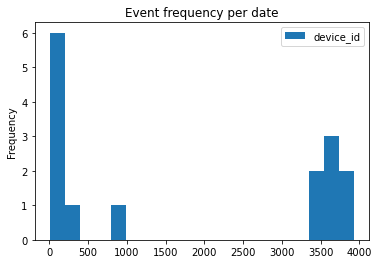

In [51]:
# need to check if there is no irrelevant data
time_stat = df.groupby('date').agg({'device_id':'nunique'})
time_stat.plot.hist(bins=20)
plt.title('Event frequency per date')
plt.show()


Seems that there is old irrelevn data in the file

In [17]:
time_stat = time_stat.reset_index()
time_stat

,date,device_id
0,2019-07-25,7
1,2019-07-26,21
2,2019-07-27,39
3,2019-07-28,68
4,2019-07-29,132
5,2019-07-30,283
6,2019-07-31,798
7,2019-08-01,3688
8,2019-08-02,3641
9,2019-08-03,3472


In [52]:
# Deleting irrelevn data
df_new = df[(df['date'] > dt.date(2019, 7, 31)) & (df['date'] < dt.date(2019, 8, 8))]

In [53]:
# How many data we have filtered out? 
time_stat_new = df_new.groupby('date').agg({'device_id':'nunique'})
was_filt = abs(round((time_stat_new.device_id.sum() / time_stat.device_id.sum()-1)*100, 1))

users_was_filt = abs(round((len(df_new.device_id.unique()) / len(df.device_id.unique())-1)*100, 1))

print(f'After filtering we lost {was_filt}% events')
print(f'After filtering we lost {users_was_filt}% users')


After filtering we lost 5.1% events
After filtering we lost 0.2% users


# Step 3. Funnel analysis

In [21]:
df_new.event_type.value_counts(ascending=False)

MainScreenAppear           117850
OffersScreenAppear          46509
CartScreenAppear            42338
PaymentScreenSuccessful     33949
Tutorial                     1010
Name: event_type, dtype: int64

In [54]:
# calculating users per each event type
event_stat = (df_new.groupby('event_type')
              .agg({'device_id':'nunique'})
              .sort_values('device_id', ascending=False)
              .reset_index()
              
)
event_stat.columns = ['event_type', 'user_cnt']
event_stat

,event_type,user_cnt
0,MainScreenAppear,7423
1,OffersScreenAppear,4596
2,CartScreenAppear,3736
3,PaymentScreenSuccessful,3540
4,Tutorial,843


In [55]:
# Calculating event type shares from all users

event_stat['share_from_all'] = event_stat.user_cnt / len(df_new.device_id.unique())
event_stat

,event_type,user_cnt,share_from_all
0,MainScreenAppear,7423,0.984744
1,OffersScreenAppear,4596,0.609711
2,CartScreenAppear,3736,0.495622
3,PaymentScreenSuccessful,3540,0.469621
4,Tutorial,843,0.111833


The flow is followint: 
- MainScreenAppear
- OffersScreenAppear
- CartScreenAppear
- PaymentScreenSuccessful

Tutorial is not in the purchase jouney 

Seems that not all the users went throw first event MainScreenAppear. Probably some came directly to the Offer of saw only Tutorial


In [57]:
# Calculating cj statistic
cjm_stat = event_stat.query('event_type != "Tutorial"').copy()
cjm_stat['conversion_by_step'] = cjm_stat['user_cnt'] / cjm_stat['user_cnt'].shift(fill_value=cjm_stat.loc[0,'user_cnt'])
cjm_stat['conversion_by_step'] = cjm_stat.conversion_by_step.apply('{:.2}'.format)
cjm_stat


,event_type,user_cnt,share_from_all,conversion_by_step
0,MainScreenAppear,7423,0.984744,1.0
1,OffersScreenAppear,4596,0.609711,0.62
2,CartScreenAppear,3736,0.495622,0.81
3,PaymentScreenSuccessful,3540,0.469621,0.95


In [58]:
fig = go.Figure(
    go.Funnel(
        y=cjm_stat['event_type'],
        x=cjm_stat['user_cnt']
    )
)

fig.update_layout(title='Purchase funnel plot')
fig.show()

Seems that we lose the most of users on the second step

In [59]:
# Which share from all come to the end?

cjm_stat.loc[:,'conversion_total'] = (cjm_stat.loc[:,'user_cnt'] / cjm_stat.loc[0,'user_cnt'])
cjm_stat.loc[:,'conversion_total'] = cjm_stat['conversion_total'].apply('{:.2}'.format)
cjm_stat

,event_type,user_cnt,share_from_all,conversion_by_step,conversion_total
0,MainScreenAppear,7423,0.984744,1.0,1.0
1,OffersScreenAppear,4596,0.609711,0.62,0.62
2,CartScreenAppear,3736,0.495622,0.81,0.5
3,PaymentScreenSuccessful,3540,0.469621,0.95,0.48


# Step 5. AB test analysis

In [62]:
# How many people in each group?

df_new.groupby('group').agg({'device_id':'nunique'})


,device_id
group,
246,2484
247,2517
248,2537


In [32]:
user_group_stat.sum()

device_id    7538
dtype: int64

In [33]:
len(df_new.device_id.unique())

7538

Summ in the freq table equals to total number of users. It means that we do not have users fell into two+ groups


In [69]:
# z-test function
def z_test(share1, share2, s_size1, s_size2, alpha=.05):
    
    p1 = share1 / s_size1
    p2 = share2 / s_size2

    p_combined = ((share1 + share2) / 
              (s_size1 + s_size2))

    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/s_size1 + 1/s_size2))

    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    p_value = round(p_value, 3)

    if p_value < alpha:
        print('p-value: ', p_value, ', null hypothesis CAN be rejected')
    else: print('p-value: ', p_value, ', null hypothesis can NOT be rejected')

In [66]:
# Function for conversion stat creation

def fcjm_stat(data):
    
    
    event_st = (data.groupby('event_type')
              .agg({'device_id':'nunique'})
              .sort_values('device_id', ascending=False)           
              
    )
    
    event_st.loc['Total','device_id'] = len(data.device_id.unique())
    event_st = event_st.drop(['Tutorial']).copy()

    event_st = event_st.reset_index()
    event_st.columns = ['event_type', 'user_cnt']
    
    event_st.loc[:3,'conversion_by_step'] = (event_st['user_cnt'] / event_st['user_cnt']
                                      .shift(fill_value=event_st.loc[0,'user_cnt'])
    )
    event_st['conversion_by_step'] = event_st.conversion_by_step.apply('{:.2}'.format)
    event_st.loc[:3,'conversion_total'] = (event_st.loc[:,'user_cnt'] / len(data.device_id.unique())) 
    event_st.loc[:3,'conversion_total'] = event_st['conversion_total'].apply('{:.2}'.format)

    
    return event_st
    


First of all we need to compare A1 and A2 groups in order to be sured that separation went fine

In [64]:
# A1 group

stat_246 = fcjm_stat(df_new.query('group == 246'))
stat_246

,event_type,user_cnt,conversion_by_step,conversion_total
0,MainScreenAppear,2450.0,1.0,0.99
1,OffersScreenAppear,1542.0,0.63,0.62
2,CartScreenAppear,1266.0,0.82,0.51
3,PaymentScreenSuccessful,1200.0,0.95,0.48
4,Total,2484.0,nan,NaN


In [37]:
# A2 group
stat_247 = fcjm_stat(df_new.query('group == 247'))
stat_247

,event_type,user_cnt,conversion_by_step,conversion_total
0,MainScreenAppear,2479.0,1.0,0.98
1,OffersScreenAppear,1523.0,0.61,0.61
2,CartScreenAppear,1239.0,0.81,0.49
3,PaymentScreenSuccessful,1158.0,0.93,0.46
4,Total,2517.0,nan,NaN


In [67]:
# Function for stat comparison with Z-test

def check_by_step(data1, data2, alpha=.05):  
    for i in range(len(data1.user_cnt)-1):
        share1 = data1.loc[i, 'user_cnt']
        share2 = data2.loc[i, 'user_cnt']
        ssize1 = data1.loc[4, 'user_cnt']
        ssize2 = data2.loc[4, 'user_cnt']
        print(data1.loc[i, 'event_type'], ':')
        z_test(share1, share2, ssize1, ssize2, alpha=alpha)
        
        

In [70]:
# Н0 - There is NO difference between groups' conversions (from all users), 
# Н1 - There is a difference between groups' conversions (from all users)

check_by_step(stat_246, stat_247)

MainScreenAppear :
p-value:  0.676 , null hypothesis can NOT be rejected
OffersScreenAppear :
p-value:  0.255 , null hypothesis can NOT be rejected
CartScreenAppear :
p-value:  0.218 , null hypothesis can NOT be rejected
PaymentScreenSuccessful :
p-value:  0.103 , null hypothesis can NOT be rejected


## А1+A2 / B comparison

In [71]:
# creating united A group and B groups

stat_control = fcjm_stat(df_new.query('group == 246 or group == 247'))
stat_test = fcjm_stat(df_new.query('group == 248'))

check_by_step(stat_control, stat_test)

MainScreenAppear :
p-value:  0.393 , null hypothesis can NOT be rejected
OffersScreenAppear :
p-value:  0.429 , null hypothesis can NOT be rejected
CartScreenAppear :
p-value:  0.198 , null hypothesis can NOT be rejected
PaymentScreenSuccessful :
p-value:  0.645 , null hypothesis can NOT be rejected


## А1 / B Comparison 

In [72]:
# As we are conducting two consequent tests we need to apply Bonferonni correction to alpha level 
check_by_step(stat_246, stat_test, alpha=0.05/3)

MainScreenAppear :
p-value:  0.347 , null hypothesis can NOT be rejected
OffersScreenAppear :
p-value:  0.208 , null hypothesis can NOT be rejected
CartScreenAppear :
p-value:  0.083 , null hypothesis can NOT be rejected
PaymentScreenSuccessful :
p-value:  0.223 , null hypothesis can NOT be rejected


## А2 / B comparison

In [73]:

check_by_step(stat_247, stat_test, alpha=0.05/3)

MainScreenAppear :
p-value:  0.6 , null hypothesis can NOT be rejected
OffersScreenAppear :
p-value:  0.906 , null hypothesis can NOT be rejected
CartScreenAppear :
p-value:  0.617 , null hypothesis can NOT be rejected
PaymentScreenSuccessful :
p-value:  0.678 , null hypothesis can NOT be rejected


# Conclusions:

1) We lose the most of users on Offer window
2) 48% of users comes to the purchase
3) AB test results: There is no impact of the tested changes on the conversion numbers


